In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet50
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 23
train_size = 0.8

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

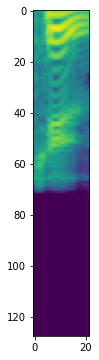

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 2):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 2):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(2)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 2)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [15]:
class AudioMNIST(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [17]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No augmentation

In [18]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = False, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
Train
1.1349847112603257
TEST
loss: 1.6901937018158615
accuracy: 0.6430107526881721
******************
epoch: 1
Train
0.4412109544987183
TEST
loss: 0.7372807834738044
accuracy: 0.8043010752688172
******************
epoch: 2
Train
0.42620986868568694
TEST
loss: 0.738446544959981
accuracy: 0.7827956989247312
******************
epoch: 3
Train
0.30518791896396896
TEST
loss: 0.3617874772958858
accuracy: 0.8817204301075269
******************
epoch: 4
Train
0.2576349927458509
TEST
loss: 0.5208777594309981
accuracy: 0.886021505376344
******************
epoch: 5
Train
0.228923450700044
TEST
loss: 0.3422632698089846
accuracy: 0.8946236559139785
******************
epoch: 6
Train
0.26776421516251037
TEST
loss: 0.5460035524060649
accuracy: 0.8387096774193549
******************
epoch: 7
Train
0.2962626815163197
TEST
loss: 0.2936588428193523
accuracy: 0.9204301075268817
******************
epoch: 8
Train
0.13500944409252624
TEST
loss: 0.2015869282907055
accuracy: 0.9376344086021505
**********

In [19]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9363166953528399


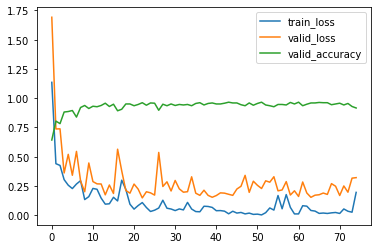

In [20]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [21]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.115169841625643
TEST
loss: 0.8530811273923484
accuracy: 0.7978494623655914
******************
epoch: 1
Train
0.5033484663318805
TEST
loss: 0.40164686954149637
accuracy: 0.8838709677419355
******************
epoch: 2
Train
0.37971784943974524
TEST
loss: 0.47051114613010037
accuracy: 0.8559139784946237
******************
epoch: 3
Train
0.40405262049385854
TEST
loss: 0.2312913296043232
accuracy: 0.9290322580645162
******************
epoch: 4
Train
0.24971668772884897
TEST
loss: 0.3409764717983943
accuracy: 0.8903225806451613
******************
epoch: 5
Train
0.3146821204603007
TEST
loss: 0.35640566432347864
accuracy: 0.8774193548387097
******************
epoch: 6
Train
0.26635740479924824
TEST
loss: 0.16912428967414364
accuracy: 0.9333333333333333
******************
epoch: 7
Train
0.21043594719969463
TEST
loss: 0.4453606576688828
accuracy: 0.8774193548387097
******************
epoch: 8
Train
0.20037713540967717
TEST
loss: 0.15495024490100082


In [22]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


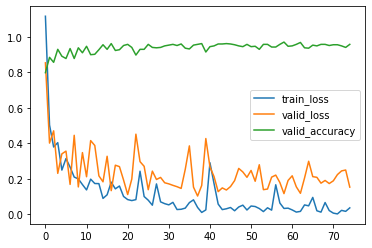

In [23]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [24]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.1584177060864211
TEST
loss: 0.7593194136055567
accuracy: 0.7978494623655914
******************
epoch: 1
Train
0.6298729230719481
TEST
loss: 0.7919699795784488
accuracy: 0.7956989247311828
******************
epoch: 2
Train
0.4617859422358121
TEST
loss: 0.3162578380236062
accuracy: 0.8774193548387097
******************
epoch: 3
Train
0.3239639716310147
TEST
loss: 0.2936428385556385
accuracy: 0.9075268817204301
******************
epoch: 4
Train
0.3026775311704727
TEST
loss: 0.310322162220555
accuracy: 0.9010752688172043
******************
epoch: 5
Train
0.33732051122682866
TEST
loss: 0.30316255425894134
accuracy: 0.8989247311827957
******************
epoch: 6
Train
0.29130736421883974
TEST
loss: 0.34841635457931025
accuracy: 0.9010752688172043
******************
epoch: 7
Train
0.23842677257365286
TEST
loss: 0.3237835666345012
accuracy: 0.8946236559139785
******************
epoch: 8
Train
0.2911663859777702
TEST
loss: 0.2587347036848466
accura

In [25]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


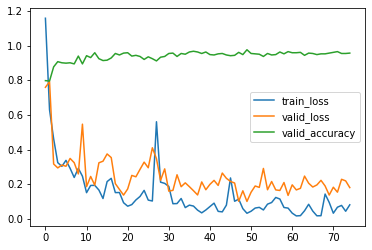

In [26]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [27]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.1098491037540301
TEST
loss: 1.153252181699199
accuracy: 0.7462365591397849
******************
epoch: 1
Train
0.4754621280286026
TEST
loss: 0.5435892010247836
accuracy: 0.8494623655913979
******************
epoch: 2
Train
0.41152720154134187
TEST
loss: 0.7657420568248277
accuracy: 0.8301075268817204
******************
epoch: 3
Train
0.31860177370573667
TEST
loss: 0.6357798443045667
accuracy: 0.8602150537634409
******************
epoch: 4
Train
0.2429080474630247
TEST
loss: 0.19766339005962494
accuracy: 0.9397849462365592
******************
epoch: 5
Train
0.1948684258170839
TEST
loss: 0.2908999760945638
accuracy: 0.9247311827956989
******************
epoch: 6
Train
0.1827169919229029
TEST
loss: 0.38448834598705334
accuracy: 0.8946236559139785
******************
epoch: 7
Train
0.22604703640000565
TEST
loss: 0.2999184473227429
accuracy: 0.9096774193548387
******************
epoch: 8
Train
0.1651335627835607
TEST
loss: 0.27623191862016594
accur

In [28]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9363166953528399


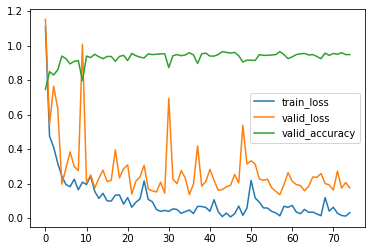

In [29]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [30]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.046590092494145
TEST
loss: 0.6573147863470098
accuracy: 0.8086021505376344
******************
epoch: 1
Train
0.47700937601848514
TEST
loss: 1.3591862241427104
accuracy: 0.7096774193548387
******************
epoch: 2
Train
0.36311971210444816
TEST
loss: 1.1189443826675416
accuracy: 0.7698924731182796
******************
epoch: 3
Train
0.37283481419182746
TEST
loss: 0.3422312940961571
accuracy: 0.8924731182795699
******************
epoch: 4
Train
0.2381750792987127
TEST
loss: 0.4332071627340009
accuracy: 0.8881720430107527
******************
epoch: 5
Train
0.2891470525748767
TEST
loss: 0.5108597347813267
accuracy: 0.8989247311827957
******************
epoch: 6
Train
0.21132730137743358
TEST
loss: 0.33989010683951837
accuracy: 0.9139784946236559
******************
epoch: 7
Train
0.17439656349588095
TEST
loss: 0.2111609990798658
accuracy: 0.9268817204301075
******************
epoch: 8
Train
0.14740639453975501
TEST
loss: 0.19158983797395743
acc

In [31]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9311531841652324


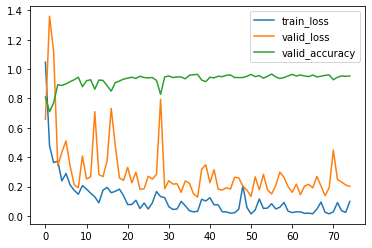

In [32]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [33]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.1661987167311152
TEST
loss: 0.8168915057374585
accuracy: 0.8043010752688172
******************
epoch: 1
Train
0.5526542126907735
TEST
loss: 0.488491488528508
accuracy: 0.8602150537634409
******************
epoch: 2
Train
0.47611458109281496
TEST
loss: 0.5797995723703856
accuracy: 0.8279569892473119
******************
epoch: 3
Train
0.38346021099634947
TEST
loss: 0.8213463658927589
accuracy: 0.8236559139784946
******************
epoch: 4
Train
0.35804376065506366
TEST
loss: 0.23346874951034463
accuracy: 0.9182795698924732
******************
epoch: 5
Train
0.3478415104799779
TEST
loss: 1.111575464663967
accuracy: 0.7462365591397849
******************
epoch: 6
Train
0.3480025335351947
TEST
loss: 0.4334970010224209
accuracy: 0.9032258064516129
******************
epoch: 7
Train
0.29124071621163017
TEST
loss: 0.17903090837181254
accuracy: 0.9354838709677419
******************
epoch: 8
Train
0.17152930570663016
TEST
loss: 0.13158337921705296
accu

In [34]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


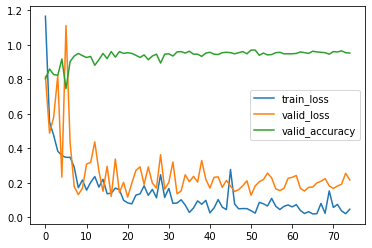

In [35]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [36]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
2.186955079123354
TEST
loss: 2.3949194728687244
accuracy: 0.3118279569892473
******************
epoch: 1
Train
1.6163779690372218
TEST
loss: 0.9129477739334106
accuracy: 0.6623655913978495
******************
epoch: 2
Train
1.4702071070863665
TEST
loss: 0.7534869668304279
accuracy: 0.7505376344086021
******************
epoch: 3
Train
1.2890729676926078
TEST
loss: 0.6203444419368621
accuracy: 0.8129032258064516
******************
epoch: 4
Train
1.1680403002886344
TEST
loss: 0.4854472513480853
accuracy: 0.832258064516129
******************
epoch: 5
Train
1.021679150268604
TEST
loss: 1.16084062668585
accuracy: 0.6709677419354839
******************
epoch: 6
Train
1.1866365475364442
TEST
loss: 0.9141102865178098
accuracy: 0.7333333333333333
******************
epoch: 7
Train
1.074888861237127
TEST
loss: 0.5487336965017421
accuracy: 0.8236559139784946
******************
epoch: 8
Train
1.0468523814335393
TEST
loss: 0.37724660035743507
accuracy: 0.870

In [37]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9156626506024096


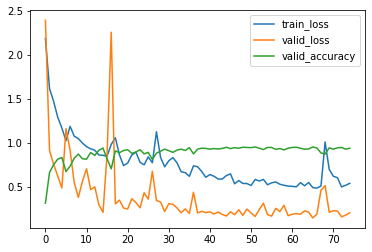

In [38]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [39]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.6956947602183188
TEST
loss: 13.992093756891066
accuracy: 0.11827956989247312
******************
epoch: 1
Train
0.7897866641441595
TEST
loss: 4.323877969864876
accuracy: 0.2903225806451613
******************
epoch: 2
Train
0.5872384402048351
TEST
loss: 1.5482977751762637
accuracy: 0.5010752688172043
******************
epoch: 3
Train
0.4612669227068053
TEST
loss: 0.6580077985281585
accuracy: 0.7784946236559139
******************
epoch: 4
Train
0.4150677263961406
TEST
loss: 0.7448398431142171
accuracy: 0.7526881720430108
******************
epoch: 5
Train
0.40115794688703943
TEST
loss: 2.4464014037962882
accuracy: 0.4
******************
epoch: 6
Train
0.5093115337702556
TEST
loss: 1.8558539059854322
accuracy: 0.5849462365591398
******************
epoch: 7
Train
0.3116064014843092
TEST
loss: 1.1280028303464253
accuracy: 0.6817204301075269
******************
epoch: 8
Train
0.2287214028302482
TEST
loss: 0.5590227125793374
accuracy: 0.851612903225

In [40]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8743545611015491


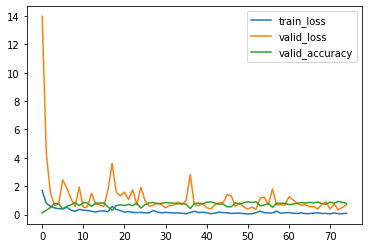

In [41]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [42]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.1962872690325086
TEST
loss: 0.7566031596993887
accuracy: 0.7655913978494624
******************
epoch: 1
Train
0.4568221239101264
TEST
loss: 0.9011956822487616
accuracy: 0.7677419354838709
******************
epoch: 2
Train
0.32507493531890114
TEST
loss: 0.8779082111133042
accuracy: 0.789247311827957
******************
epoch: 3
Train
0.34114637828091493
TEST
loss: 0.33185856912725714
accuracy: 0.8924731182795699
******************
epoch: 4
Train
0.2542755593519154
TEST
loss: 0.41090264820283456
accuracy: 0.8817204301075269
******************
epoch: 5
Train
0.2948656413718199
TEST
loss: 0.4384631657792676
accuracy: 0.8795698924731182
******************
epoch: 6
Train
0.22290203549814405
TEST
loss: 0.8701690403364037
accuracy: 0.7935483870967742
******************
epoch: 7
Train
0.2342930778612292
TEST
loss: 0.26643948333127604
accuracy: 0.9268817204301075
******************
epoch: 8
Train
0.18109383943200305
TEST
loss: 0.16752418138647593
acc

In [43]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9466437177280551


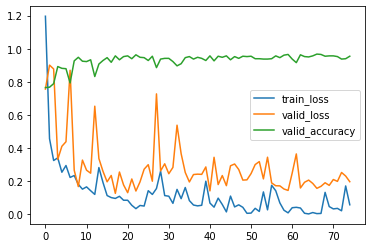

In [44]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [45]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.1454588839233595
TEST
loss: 1.6261987029865224
accuracy: 0.6666666666666666
******************
epoch: 1
Train
0.463860480324453
TEST
loss: 0.759365439414978
accuracy: 0.7935483870967742
******************
epoch: 2
Train
0.44795024966320557
TEST
loss: 0.6865172738670021
accuracy: 0.7956989247311828
******************
epoch: 3
Train
0.26365244367717094
TEST
loss: 0.32905806152410405
accuracy: 0.8903225806451613
******************
epoch: 4
Train
0.2825282208047763
TEST
loss: 0.483027744549577
accuracy: 0.8688172043010752
******************
epoch: 5
Train
0.2599001540313437
TEST
loss: 0.23203869177609363
accuracy: 0.9290322580645162
******************
epoch: 6
Train
0.21288095145823818
TEST
loss: 0.7841153180727395
accuracy: 0.8408602150537634
******************
epoch: 7
Train
0.21459263661855257
TEST
loss: 0.33014663244767856
accuracy: 0.9182795698924732
******************
epoch: 8
Train
0.19914762066716332
TEST
loss: 0.24485661183353713
accu

In [46]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9345955249569707


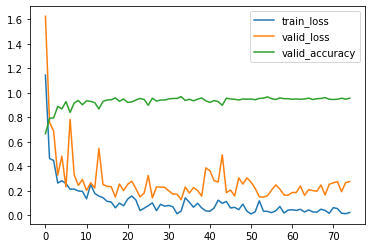

In [47]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [48]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.1723006676780194
TEST
loss: 0.7662372976221065
accuracy: 0.7698924731182796
******************
epoch: 1
Train
0.5609663143938565
TEST
loss: 1.171586940621817
accuracy: 0.7311827956989247
******************
epoch: 2
Train
0.46418499667347923
TEST
loss: 0.3530023218483053
accuracy: 0.8731182795698925
******************
epoch: 3
Train
0.3175985399727932
TEST
loss: 0.22964855275487386
accuracy: 0.9311827956989247
******************
epoch: 4
Train
0.2772064309769827
TEST
loss: 0.3294529937928723
accuracy: 0.875268817204301
******************
epoch: 5
Train
0.2957261438708698
TEST
loss: 0.5834479410802165
accuracy: 0.821505376344086
******************
epoch: 6
Train
0.3317672537422077
TEST
loss: 0.7035247325897217
accuracy: 0.7978494623655914
******************
epoch: 7
Train
0.3026088334953008
TEST
loss: 0.1918613214326161
accuracy: 0.9225806451612903
******************
epoch: 8
Train
0.18975901402288312
TEST
loss: 0.18191550726531655
accuracy:

In [49]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9294320137693631


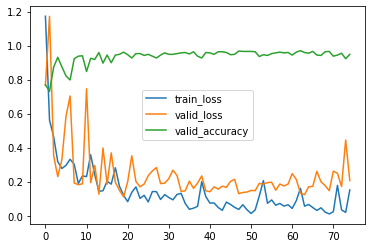

In [50]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [51]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
2.0533204294368024
TEST
loss: 2.417404342979513
accuracy: 0.46881720430107526
******************
epoch: 1
Train
1.5697743796377845
TEST
loss: 1.5611772065521567
accuracy: 0.6150537634408603
******************
epoch: 2
Train
1.3711440284597534
TEST
loss: 0.7699930508931477
accuracy: 0.7741935483870968
******************
epoch: 3
Train
1.2305848250545735
TEST
loss: 0.7687436411457677
accuracy: 0.7956989247311828
******************
epoch: 4
Train
1.1105099450405658
TEST
loss: 0.5937902171124694
accuracy: 0.8258064516129032
******************
epoch: 5
Train
0.9982139467230136
TEST
loss: 1.1935502757308303
accuracy: 0.6774193548387096
******************
epoch: 6
Train
1.097101358938551
TEST
loss: 0.6485390102991494
accuracy: 0.8021505376344086
******************
epoch: 7
Train
0.9598846720570702
TEST
loss: 0.41982612904681954
accuracy: 0.8623655913978494
******************
epoch: 8
Train
0.9290140752325022
TEST
loss: 0.5369504747852203
accuracy: 

In [52]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8950086058519794


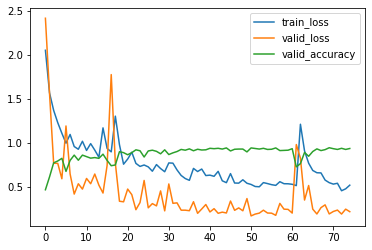

In [53]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [54]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.277737147973697
TEST
loss: 1.237922150601623
accuracy: 0.6709677419354839
******************
epoch: 1
Train
0.5121784302645238
TEST
loss: 0.5981199350408328
accuracy: 0.8258064516129032
******************
epoch: 2
Train
0.4498110082628397
TEST
loss: 0.5453556924096999
accuracy: 0.821505376344086
******************
epoch: 3
Train
0.36848694955911054
TEST
loss: 0.5075935152269179
accuracy: 0.8602150537634409
******************
epoch: 4
Train
0.318941709426506
TEST
loss: 0.5982658047829905
accuracy: 0.843010752688172
******************
epoch: 5
Train
0.2575702178715761
TEST
loss: 0.6121686280414622
accuracy: 0.8301075268817204
******************
epoch: 6
Train
0.29380773859250015
TEST
loss: 0.32224731829858594
accuracy: 0.9053763440860215
******************
epoch: 7
Train
0.2911242704976934
TEST
loss: 0.3150284107013415
accuracy: 0.9010752688172043
******************
epoch: 8
Train
0.2519994165605926
TEST
loss: 0.1576370987840878
accuracy: 0.

In [55]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9483648881239243


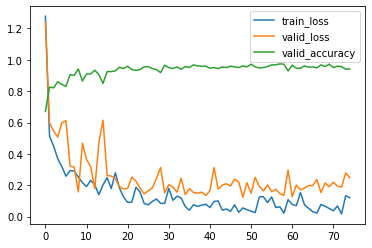

In [56]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [57]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
2.007603072452494
TEST
loss: 1.9993169743527648
accuracy: 0.5741935483870968
******************
epoch: 1
Train
1.4767235795464255
TEST
loss: 1.6656438945442118
accuracy: 0.5956989247311828
******************
epoch: 2
Train
1.2570266913006751
TEST
loss: 0.7383440797046948
accuracy: 0.7978494623655914
******************
epoch: 3
Train
1.1997830008844181
TEST
loss: 0.9899231879941879
accuracy: 0.7096774193548387
******************
epoch: 4
Train
1.0937621173642949
TEST
loss: 1.0592434601117207
accuracy: 0.7526881720430108
******************
epoch: 5
Train
1.075207537711148
TEST
loss: 0.48026992191550555
accuracy: 0.8279569892473119
******************
epoch: 6
Train
1.1004825924825592
TEST
loss: 0.43743025923288
accuracy: 0.8602150537634409
******************
epoch: 7
Train
0.9858057154849067
TEST
loss: 0.36218815093399376
accuracy: 0.886021505376344
******************
epoch: 8
Train
0.9502942321373689
TEST
loss: 0.6723087807496388
accuracy: 0.8

In [58]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9311531841652324


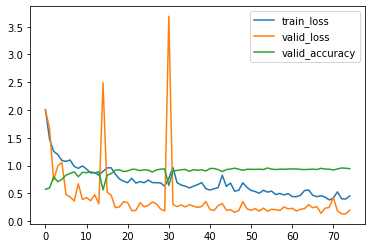

In [59]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [60]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.2033072326795735
TEST
loss: 1.2418646684256933
accuracy: 0.7440860215053764
******************
epoch: 1
Train
0.48170333930607695
TEST
loss: 0.9292548128353653
accuracy: 0.7913978494623656
******************
epoch: 2
Train
0.4004992300872207
TEST
loss: 0.38039930417973505
accuracy: 0.8946236559139785
******************
epoch: 3
Train
0.3337326957515702
TEST
loss: 0.23675787250200908
accuracy: 0.9053763440860215
******************
epoch: 4
Train
0.3108166334894824
TEST
loss: 0.257063647431712
accuracy: 0.9139784946236559
******************
epoch: 5
Train
0.25016792769321655
TEST
loss: 0.2502669115921342
accuracy: 0.9139784946236559
******************
epoch: 6
Train
0.16339283021278259
TEST
loss: 0.20979024389738676
accuracy: 0.9333333333333333
******************
epoch: 7
Train
0.28542791408881363
TEST
loss: 1.0202803340009463
accuracy: 0.8064516129032258
******************
epoch: 8
Train
0.22204833039206462
TEST
loss: 0.18426782700323288
ac

In [61]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9380378657487092


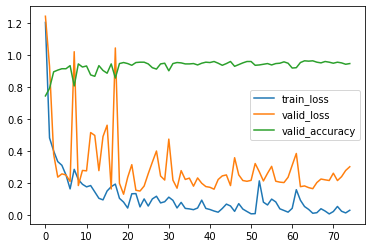

In [62]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [63]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.3194276760134187
TEST
loss: 1.0644642449194386
accuracy: 0.7118279569892473
******************
epoch: 1
Train
0.6449321595070243
TEST
loss: 1.130806161511329
accuracy: 0.6903225806451613
******************
epoch: 2
Train
0.4889651092554718
TEST
loss: 0.6094905908389758
accuracy: 0.8236559139784946
******************
epoch: 3
Train
0.34504132406905447
TEST
loss: 0.5691518143940998
accuracy: 0.810752688172043
******************
epoch: 4
Train
0.38686908546415916
TEST
loss: 1.527602627456829
accuracy: 0.7483870967741936
******************
epoch: 5
Train
0.3036648687908068
TEST
loss: 0.6733801454626104
accuracy: 0.821505376344086
******************
epoch: 6
Train
0.2971364186377569
TEST
loss: 0.3578592004474773
accuracy: 0.8924731182795699
******************
epoch: 7
Train
0.3248131894012517
TEST
loss: 0.41793592790121675
accuracy: 0.8795698924731182
******************
epoch: 8
Train
0.3076028480411667
TEST
loss: 0.2396483580271403
accuracy: 0

In [64]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9397590361445783


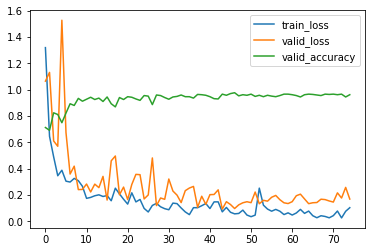

In [65]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [66]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.116185872992586
TEST
loss: 0.6370802056404852
accuracy: 0.821505376344086
******************
epoch: 1
Train
0.4652160975518378
TEST
loss: 2.376095148312148
accuracy: 0.6236559139784946
******************
epoch: 2
Train
0.40529779540189315
TEST
loss: 0.5286677401552918
accuracy: 0.8559139784946237
******************
epoch: 3
Train
0.28885941352649086
TEST
loss: 0.21991211432282642
accuracy: 0.9225806451612903
******************
epoch: 4
Train
0.24429811735466467
TEST
loss: 0.2940111204541178
accuracy: 0.9118279569892473
******************
epoch: 5
Train
0.22230369959971438
TEST
loss: 0.8650534365766792
accuracy: 0.8301075268817204
******************
epoch: 6
Train
0.27716495667212615
TEST
loss: 0.35951653988130633
accuracy: 0.9118279569892473
******************
epoch: 7
Train
0.19882097026643153
TEST
loss: 0.21267350713411967
accuracy: 0.9290322580645162
******************
epoch: 8
Train
0.1640372871068709
TEST
loss: 0.5807103385367701
accu

In [67]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9414802065404475


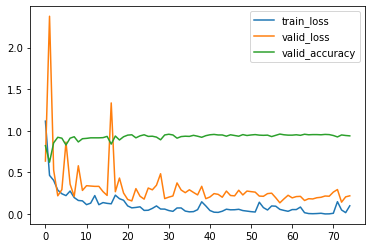

In [68]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [69]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.0820968519569278
TEST
loss: 0.5512550138658093
accuracy: 0.843010752688172
******************
epoch: 1
Train
0.47173063807674936
TEST
loss: 0.5424424049674824
accuracy: 0.832258064516129
******************
epoch: 2
Train
0.48120399174923917
TEST
loss: 0.6154162262075691
accuracy: 0.8129032258064516
******************
epoch: 3
Train
0.38744899157111723
TEST
loss: 0.6955745835458079
accuracy: 0.8129032258064516
******************
epoch: 4
Train
0.2615362571398931
TEST
loss: 0.2272166802678057
accuracy: 0.9311827956989247
******************
epoch: 5
Train
0.31562941820312074
TEST
loss: 0.5325974119927294
accuracy: 0.8387096774193549
******************
epoch: 6
Train
0.327271751389429
TEST
loss: 0.30110189895476064
accuracy: 0.896774193548387
******************
epoch: 7
Train
0.2773329918270286
TEST
loss: 0.26293926892742037
accuracy: 0.9247311827956989
******************
epoch: 8
Train
0.1815247554963933
TEST
loss: 0.27590328031970607
accurac

In [70]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9518072289156626


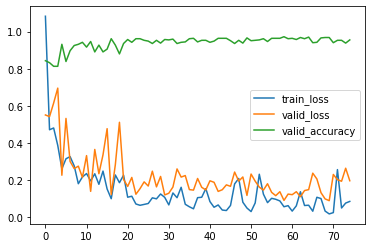

In [71]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [72]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.216120875132103
TEST
loss: 3.3183193929733767
accuracy: 0.5053763440860215
******************
epoch: 1
Train
0.5449810625085538
TEST
loss: 0.5032503648470806
accuracy: 0.8473118279569892
******************
epoch: 2
Train
0.40189692551369427
TEST
loss: 0.4338208080860235
accuracy: 0.8774193548387097
******************
epoch: 3
Train
0.34162657454762335
TEST
loss: 0.30889494681871066
accuracy: 0.9032258064516129
******************
epoch: 4
Train
0.27789424476151064
TEST
loss: 0.2597097116131936
accuracy: 0.9225806451612903
******************
epoch: 5
Train
0.261136089914514
TEST
loss: 0.3542819240400868
accuracy: 0.8881720430107527
******************
epoch: 6
Train
0.2942414947524145
TEST
loss: 0.2762451360943497
accuracy: 0.9139784946236559
******************
epoch: 7
Train
0.25365354068573276
TEST
loss: 0.189210622092729
accuracy: 0.9354838709677419
******************
epoch: 8
Train
0.1983037129421676
TEST
loss: 0.2852326014509765
accuracy

In [73]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


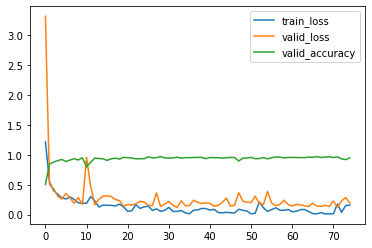

In [74]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [75]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.5527491158673887
TEST
loss: 1.8874320645486156
accuracy: 0.6150537634408603
******************
epoch: 1
Train
0.7228653473307127
TEST
loss: 0.4643801037342318
accuracy: 0.843010752688172
******************
epoch: 2
Train
0.6653953365375743
TEST
loss: 0.24052315554631654
accuracy: 0.9268817204301075
******************
epoch: 3
Train
0.44545065592743727
TEST
loss: 0.34784844742026383
accuracy: 0.886021505376344
******************
epoch: 4
Train
0.387846902036898
TEST
loss: 0.1997616581859127
accuracy: 0.9419354838709677
******************
epoch: 5
Train
0.35665053286472825
TEST
loss: 0.3942483370422676
accuracy: 0.9032258064516129
******************
epoch: 6
Train
0.3792943623223867
TEST
loss: 0.22325871163798916
accuracy: 0.9247311827956989
******************
epoch: 7
Train
0.37110066850402373
TEST
loss: 0.30344268109208794
accuracy: 0.9139784946236559
******************
epoch: 8
Train
0.26827027159605094
TEST
loss: 0.35111750201672637
accu

In [76]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9397590361445783


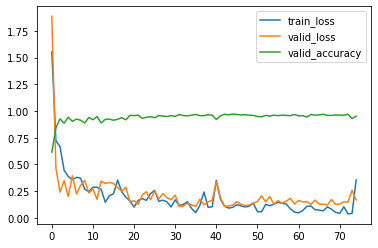

In [77]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()